In [2]:
pip install sdgne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install gretel-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.6/531.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.7 MB/s eta 0:00:00


In [24]:
df = pd.read_excel('Combined_AM_Data.xlsx')
X = df.drop('class', axis=1)
y = df['class']

In [25]:
df.head()

,id,date,age,sex,BMI,income,road_dist,cooking,am_pef_org,y_am_pef,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,SB-001,2017-11-02,66,1,31.766,0.0,0.5,0.5,125.0,0.284,...,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836,0
1,SB-001,2017-11-03,66,1,31.766,0.0,0.5,0.5,244.0,0.000,...,0.281,0.851,0.832,0.933,0.454,0.437,0.083,0.112,0.815,0
2,SB-001,2017-11-04,66,1,31.766,0.0,0.5,0.5,339.0,0.264,...,0.692,0.430,0.367,0.647,0.646,0.633,0.575,0.235,0.644,1
3,SB-001,2017-11-05,66,1,31.766,0.0,0.5,0.5,301.0,0.475,...,0.190,0.260,0.248,0.544,0.898,0.883,0.746,0.274,0.601,1
4,SB-001,2017-11-06,66,1,31.766,0.0,0.5,0.5,255.0,0.390,...,0.089,0.463,0.428,0.708,0.815,0.796,0.492,0.232,0.710,1


In [5]:
ids   = df['id'].values
y_old = df['class'].values
X_old = df.drop(['id','date','class'], axis=1).values

In [8]:
print("Imbalance Count:")
print(df['class'].value_counts())

Imbalance Count:
class
1    2925
0    1137
Name: count, dtype: int64


In [72]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, pairwise_distances
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [57]:
def hassanat_dist(p, q):
    pi, qi = p, q
    d = np.zeros_like(pi, dtype=float)
    # non-negative features
    mask = np.minimum(pi, qi) >= 0
    mn, mx = np.minimum(pi[mask], qi[mask]), np.maximum(pi[mask], qi[mask])
    d[mask] = 1 - (1 + mn) / (1 + mx)
    # negative features
    mask2 = ~mask
    mn2, mx2 = np.minimum(pi[mask2], qi[mask2]), np.maximum(pi[mask2], qi[mask2])
    d[mask2] = 1 - (1 + mn2 + np.abs(mn2)) / (1 + mx2 + np.abs(mn2))
    return d.sum()

In [58]:
id_col = 'patient_id'   # ← replace with your actual ID‐column name
class_col = 'class'

In [59]:
# 4) Select only numeric features for distance computations
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 5) Split 60% train / 40% test, stratified by class
df_train, df_test = train_test_split(
    df, train_size=0.6, stratify=df[class_col], random_state=42
)


In [60]:
# 6) Extract numeric matrices and labels
X_train = df_train[feature_cols].values
y_train = df_train[class_col].values
X_test  = df_test[feature_cols].values
y_test  = df_test[class_col].values


In [61]:
# 7) Determine minority vs majority labels
counts     = df[class_col].value_counts()
maj_label  = counts.idxmax()
min_label  = counts.idxmin()

In [70]:
id_col = 'id'
# 8) Pull out minority samples and their IDs from the training set
mask_min = df_train[class_col] == min_label
X_min    = df_train.loc[mask_min, feature_cols].values
ids_min  = df_train.loc[mask_min, id_col].values # This line should now work without error

In [66]:
# 9) Compute k‐NN indices among minority samples (for SMOTE)
k    = min(5, len(X_min))
nbrs = NearestNeighbors(n_neighbors=k).fit(X_min)
knn_inds = nbrs.kneighbors(X_min, return_distance=False)


In [67]:
# 10) Generate k synthetic samples per minority patient and validate
records = []
rng     = np.random.RandomState(42)

for i, pid in enumerate(ids_min):
    for _ in range(k):
        neighs = knn_inds[i]
        # choose a neighbor != itself if possible
        j = rng.choice(neighs[neighs != i]) if len(neighs) > 1 else i
        δ = rng.rand()
        synth = X_min[i] + δ * (X_min[j] - X_min[i])
        # compute Hassanat distance to every test sample
        dists = np.array([hassanat_dist(synth, t) for t in X_test])
        nn    = np.argmin(dists)
        # error = 1 if nearest test neighbor is majority
        records.append({'patient_id': pid, 'error': int(y_test[nn] == maj_label)})



In [68]:
# 11) Aggregate per‐patient error rates
err_df = pd.DataFrame(records)
per_patient = err_df.groupby('patient_id')['error'].mean().reset_index()
per_patient.columns = ['patient_id', 'smote_error_rate']

In [69]:
# 12) Output results
print(per_patient)
per_patient.to_excel('per_patient_smote_error.xlsx', index=False)

   patient_id  smote_error_rate
0      SB-001          0.056250
1      SB-003          0.378378
2      SB-008          0.191667
3      SB-011          0.019355
4      SB-012          0.094737
5      SB-022          0.130000
6      SB-023          0.333333
7      SB-025          0.133333
8      SB-028          0.095238
9      SB-033          0.388889
10     SB-037          0.083333
11     SB-043          0.321053
12     SB-056          0.255172
13     SB-059          0.095652
14     SB-060          0.128571
15     SB-070          0.121053
16     SB-071          0.428571
17     SB-073          0.125000
18     SB-078          0.223077
19     SB-079          0.072727
20     SB-080          0.260606
21     SB-081          0.066667
22     SB-082          0.104000
23     SB-083          0.041176
24     SB-089          0.236364
25     SB-112          0.047059


Risky patients (error_rate > 0.30):
patient_id  smote_error_rate
    SB-003          0.378378
    SB-023          0.333333
    SB-033          0.388889
    SB-043          0.321053
    SB-071          0.428571

Safe patients (error_rate < 0.10):
patient_id  smote_error_rate
    SB-001          0.056250
    SB-011          0.019355
    SB-012          0.094737
    SB-028          0.095238
    SB-037          0.083333
    SB-059          0.095652
    SB-079          0.072727
    SB-081          0.066667
    SB-083          0.041176
    SB-112          0.047059

Overall average error rate: 0.170


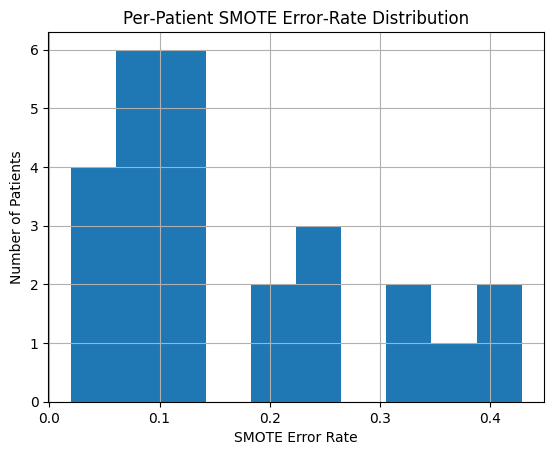

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read in the per-patient error file you generated
df = pd.read_excel('per_patient_smote_error.xlsx')

# 2) Define thresholds
risk_thresh = 0.30
safe_thresh = 0.10

# 3) Identify risky vs. safe
risky = df[df.smote_error_rate > risk_thresh]
safe  = df[df.smote_error_rate < safe_thresh]

print("Risky patients (error_rate > 0.30):")
print(risky.to_string(index=False))

print("\nSafe patients (error_rate < 0.10):")
print(safe.to_string(index=False))

# 4) Group analysis: overall average and histogram
print(f"\nOverall average error rate: {df.smote_error_rate.mean():.3f}")

plt.figure()
df.smote_error_rate.hist(bins=10)
plt.title('Per‑Patient SMOTE Error‑Rate Distribution')
plt.xlabel('SMOTE Error Rate')
plt.ylabel('Number of Patients')
plt.show()
